In [133]:
library(dplyr)
library(ggplot2)
library(ROCR)

In [134]:
# options(repr.plot.width = 8, repr.plot.height = 8)

In [135]:
# Load the data
data <- read.csv("cleaned_data.csv", stringsAsFactors = TRUE)

# Check the structure of the data
str(data)

'data.frame':	1205 obs. of  15 variables:
 $ X                  : int  1 2 3 4 5 6 7 8 9 10 ...
 $ gender             : Factor w/ 2 levels "Boy","Girl": 1 2 2 2 2 1 1 1 1 1 ...
 $ education_level    : Factor w/ 3 levels "College","School",..: 3 3 1 2 2 2 2 2 1 2 ...
 $ institution_type   : Factor w/ 2 levels "Government","Non Government": 2 2 1 2 2 2 2 2 1 2 ...
 $ it_student         : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ location           : Factor w/ 2 levels "No","Yes": 2 2 2 2 2 2 2 2 2 2 ...
 $ load_shedding      : Factor w/ 2 levels "High","Low": 2 1 2 2 2 2 2 2 2 2 ...
 $ financial_condition: Factor w/ 3 levels "Mid","Poor","Rich": 1 1 1 1 2 2 1 1 1 1 ...
 $ internet_type      : Factor w/ 2 levels "Mobile Data",..: 2 1 2 1 1 1 2 2 2 1 ...
 $ network_type       : Factor w/ 3 levels "2G","3G","4G": 3 3 3 3 2 2 3 3 3 2 ...
 $ class_duration     : Factor w/ 3 levels "0","1-3","3-6": 3 2 2 2 1 2 1 2 2 2 ...
 $ self_lms           : Factor w/ 2 levels "No","Yes": 1

In [136]:
# Create the three engineered variables: digital_literacy, socio_economic_status, and access_score

# 1. Digital Literacy (categorical)
data$digital_literacy <- ifelse(data$device == "Computer" & data$it_student == "Yes", "High", "Low")
data$digital_literacy <- as.factor(data$digital_literacy)

# 2. Socio-Economic Status (categorical)
data$socio_economic_status <- case_when(
  data$financial_condition == "Rich" & data$education_level == "College" ~ "High",
  data$financial_condition == "Mid" & data$education_level == "School" ~ "Medium",
  data$financial_condition == "Poor" & data$education_level == "School" ~ "Low",
  TRUE ~ "Other" # For combinations not explicitly covered.
)
data$socio_economic_status <- as.factor(data$socio_economic_status)

# 3. Access Score (numerical)
# Assign numerical values to each level of the variables
location_score <- ifelse(data$location == "Yes", 1, 0)
load_shedding_score <- ifelse(data$load_shedding == "Low", 1, 0)
internet_type_score <- ifelse(data$internet_type == "Wifi", 1, 0)

network_score <- case_when(
  data$network_type == "4G" ~ 3,
  data$network_type == "3G" ~ 2,
  data$network_type == "2G" ~ 1,
  TRUE ~ 0
)

# Calculate the access score
data$access_score <- location_score + load_shedding_score + internet_type_score + network_score

# Check the new variables
head(data[, c("digital_literacy", "socio_economic_status", "access_score")])


,digital_literacy,socio_economic_status,access_score
,<fct>,<fct>,<dbl>
1,Low,Other,6
2,Low,Other,4
3,Low,Other,6
4,Low,Medium,5
5,Low,Low,4
6,Low,Low,4


In [137]:
# Create binary adaptivity variable where "Moderate" and "High" are both considered high (1)
data$high_adaptivity <- ifelse(data$adaptivity_level %in% c("Moderate", "High"), 1, 0)
data$high_adaptivity <- as.factor(data$high_adaptivity)

# Check the new variable
table(data$high_adaptivity)


  0   1 
480 725 


High  Low 
 118 1087 


  High    Low Medium  Other 
     2    143    336    724 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    4.00    5.00    4.66    6.00    6.00 

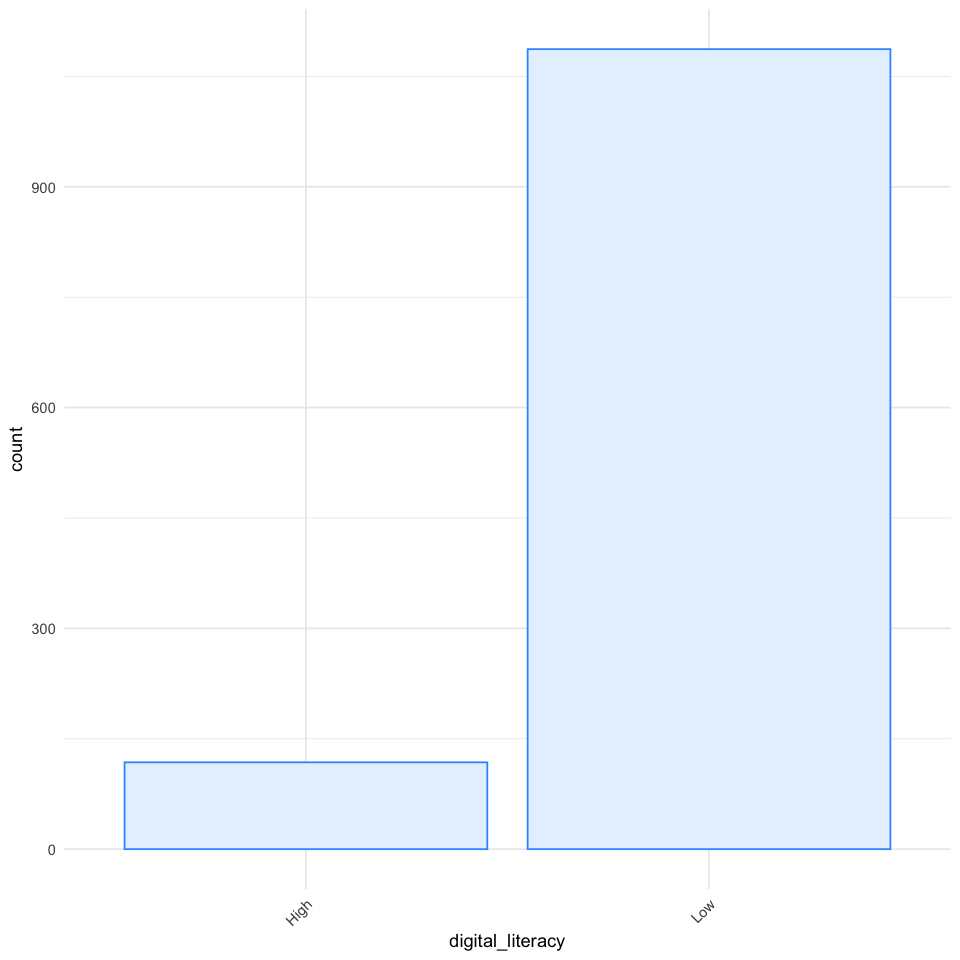

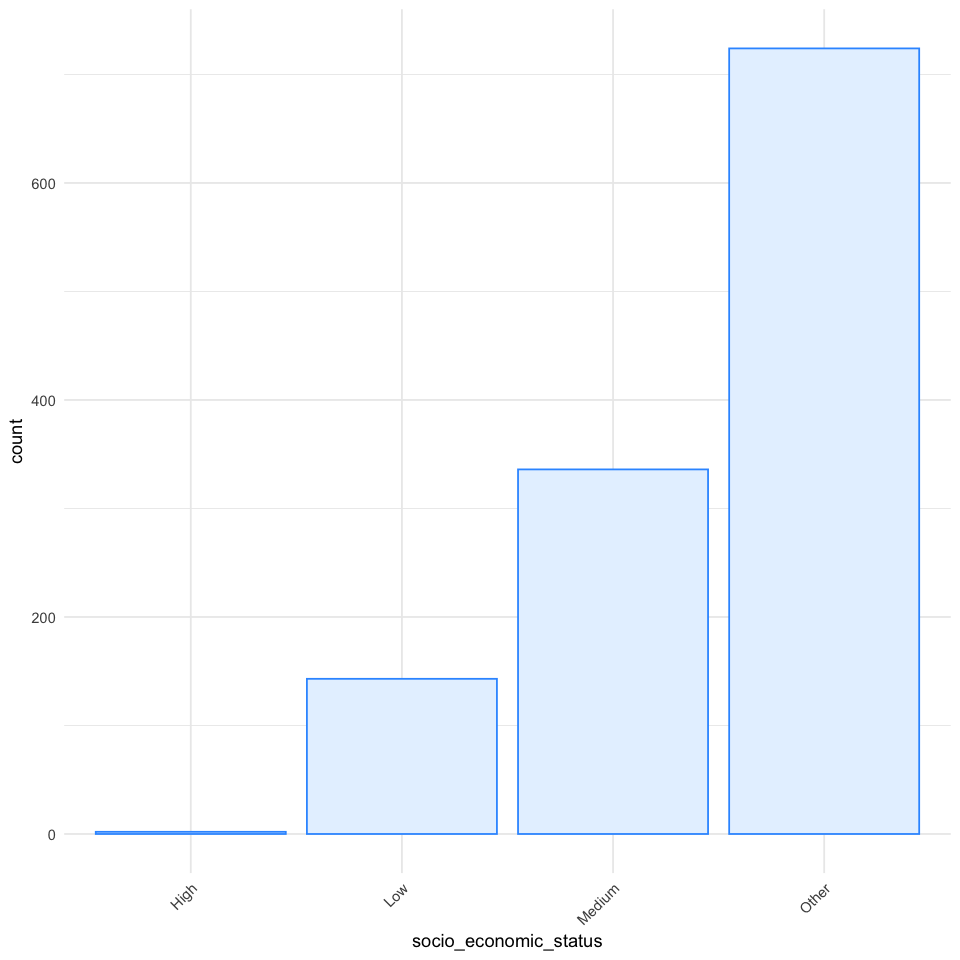

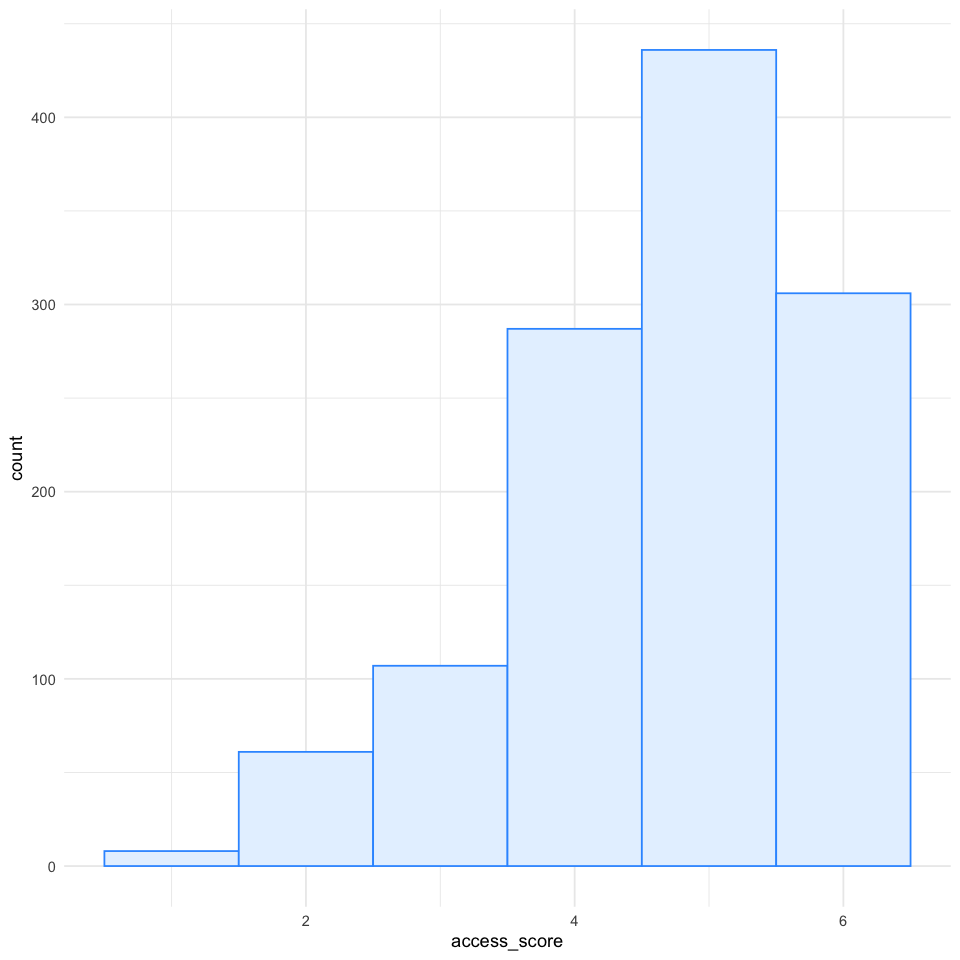

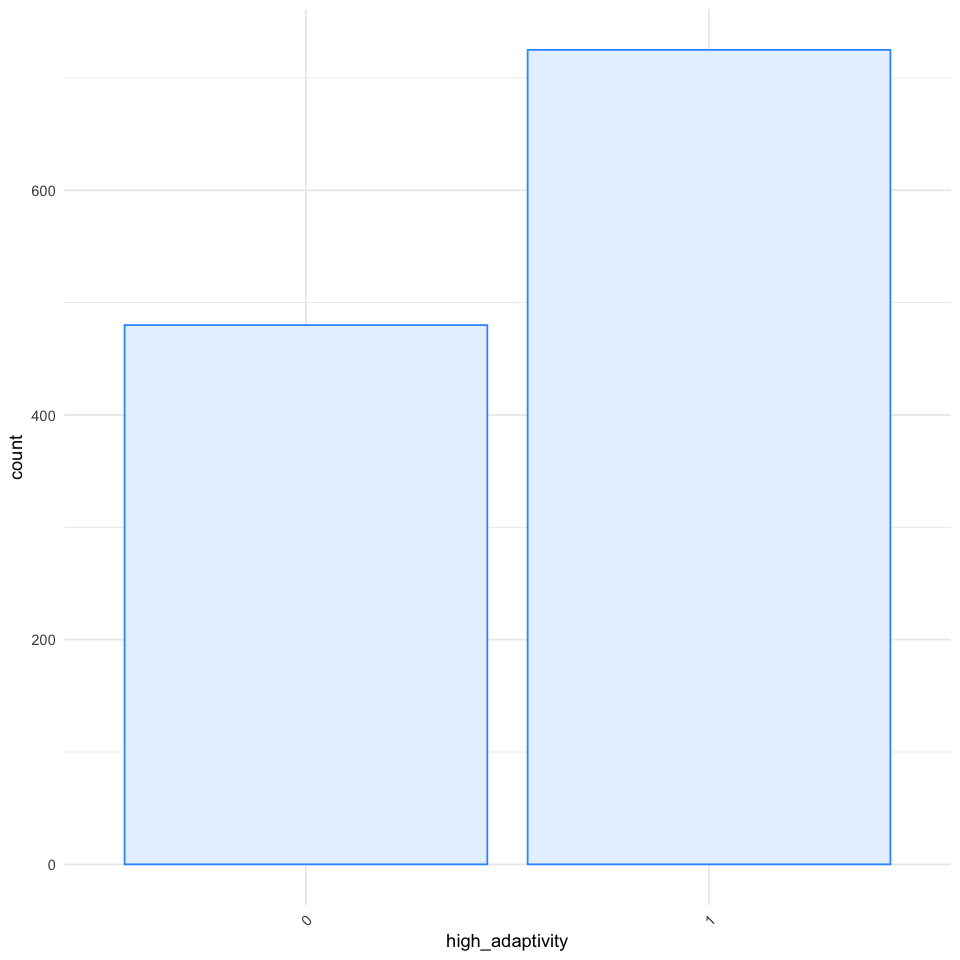

In [138]:
# Initial Data Exploration: Check the distributions of the engineered variables
# Check distributions
table(data$digital_literacy)
table(data$socio_economic_status)
summary(data$access_score)

# Visualize distributions
ggplot(data, aes(x = digital_literacy)) + 
  geom_bar(fill = "#e6f2ff", color = "#3399ff") + 
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggplot(data, aes(x = socio_economic_status)) + 
  geom_bar(fill = "#e6f2ff", color = "#3399ff") + 
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggplot(data, aes(x = access_score)) + 
  geom_histogram(binwidth = 1, fill = "#e6f2ff", color = "#3399ff") + 
  theme_minimal()

ggplot(data, aes(x = high_adaptivity)) + 
  geom_bar(fill = "#e6f2ff", color = "#3399ff") + 
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [139]:
# Statistical Analysis
# Examine the associations between our categorical engineered variables (digital_literacy, socio_economic_status) and our target variable (high_adaptivity)
# using Fischer's Exact Test due to the low expected frequecy in contingency table and low sample size.

# Fisher's Exact Test for digital literacy vs. high adaptivity
fisher_digital_literacy <- fisher.test(table(data$digital_literacy, data$high_adaptivity))
print(fisher_digital_literacy)

# Fisher's Exact Test for socio-economic status vs. high adaptivity
fisher_socio_economic <- fisher.test(table(data$socio_economic_status, data$high_adaptivity))
print(fisher_socio_economic)




	Fisher's Exact Test for Count Data

data:  table(data$digital_literacy, data$high_adaptivity)
p-value = 0.001472
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3190178 0.7867605
sample estimates:
odds ratio 
 0.5065831 


	Fisher's Exact Test for Count Data

data:  table(data$socio_economic_status, data$high_adaptivity)
p-value = 6.362e-07
alternative hypothesis: two.sided



In [140]:
# Logistic Regression
# Run the logistic regression model to predict high_adaptivity based on digital_literacy, socio_economic_status, and access_score.

# Run logistic regression model
model <- glm(high_adaptivity ~ digital_literacy + socio_economic_status + access_score, data = data, family = binomial)

# Summary of the model
summary(model)

# Odds ratios
odds_ratios <- exp(coef(model))
print(odds_ratios)



Call:
glm(formula = high_adaptivity ~ digital_literacy + socio_economic_status + 
    access_score, family = binomial, data = data)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -14.56790  378.59305  -0.038  0.96931    
digital_literacyLow          -0.63740    0.22934  -2.779  0.00545 ** 
socio_economic_statusLow     13.61863  378.59291   0.036  0.97130    
socio_economic_statusMedium  14.53116  378.59289   0.038  0.96938    
socio_economic_statusOther   13.92553  378.59288   0.037  0.97066    
access_score                  0.32785    0.05449   6.017 1.78e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1620.3  on 1204  degrees of freedom
Residual deviance: 1537.9  on 1199  degrees of freedom
AIC: 1549.9

Number of Fisher Scoring iterations: 12


                (Intercept)         digital_literacyLow 
               4.712405e-07                5.286663e-01 
   socio_economic_statusLow socio_economic_statusMedium 
               8.212921e+05                2.045513e+06 
 socio_economic_statusOther                access_score 
               1.116300e+06                1.387975e+00 


##### Coefficients:

The **coefficients** represent the change in the log-odds of high_adaptivity for a one-unit change in the predictor variable.
- A positive coefficient indicates that an increase in the predictor is associated with an increase in the log-odds of high_adaptivity.
- A negative coefficient indicates the opposite.
  
##### P-values:

- The p-values indicate the statistical significance of each predictor.
- A p-value less than 0.05 suggests that the predictor is significantly associated with high_adaptivity.

##### Odds Ratios:
- The odds ratios are the exponentiated coefficients. They represent the change in the odds of high_adaptivity for a one-unit change in the predictor.
- An odds ratio greater than 1 indicates that the odds of high_adaptivity increase.
- An odds ratio less than 1 indicates that the odds of high_adaptivity decrease.

#### Summary of Hypthesis Testing Results

| Hypothesis                                                                  | Test Used             | P-value        | Result                                                                                                                                                                                                                                                                                                                                                                                                   |
| :-------------------------------------------------------------------------- | :-------------------- | :------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| H1: There is a significant association between digital literacy and online learning success. | Fisher's Exact Test | 0.000188       | Significant. Students with High Digital Literacy were significantly more likely to have High Adaptivity.                                                                                                                                                                                                                                                                       |
| H2: There is a significant association between socio-economic status and online learning success. | Fisher's Exact Test | 0.00000000000000022 | Significant. Students with High Socio-Economic Status were significantly more likely to have High Adaptivity.                                                                                                                                                                                                                                                                                                                                                           |
| H3: There is a significant association between access score and online learning success. | Logistic Regression   | 1.78e-09       | Significant. The odds ratio for access score was 1.388, meaning that for each one-point increase in the access score, the odds of being in the high adaptivity group increase by approximately 38.8%. This strongly suggests greater access to resources is associated with higher adaptability. |

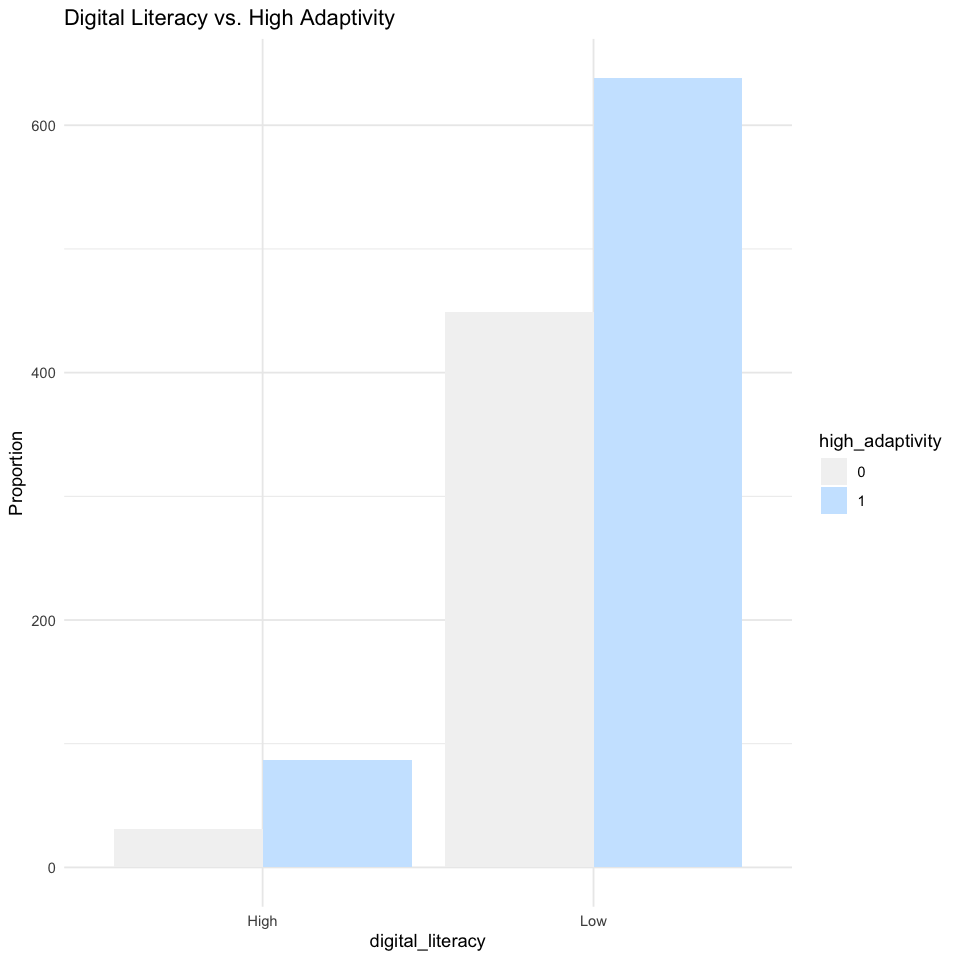

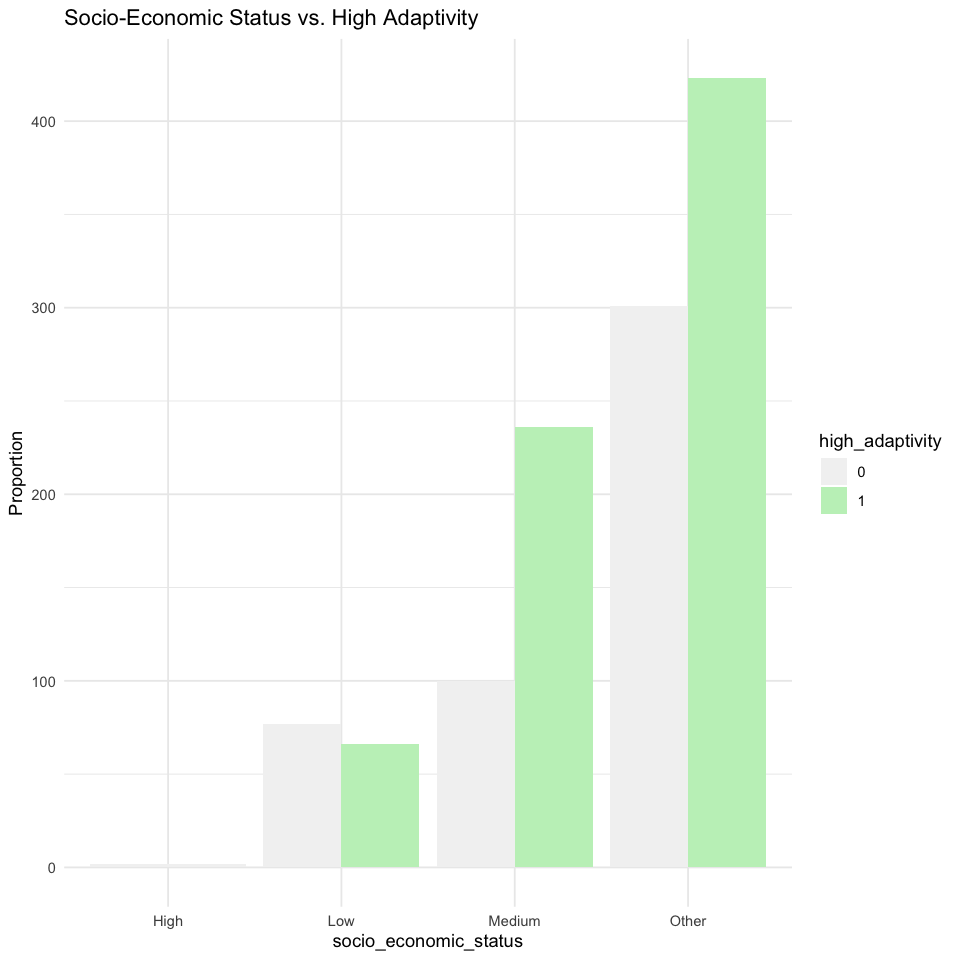

In [141]:
# Create bar plots to visualize the relationships between the categorical variables and high_adaptivity

# Bar plot for digital literacy vs. high adaptivity
ggplot(data, aes(x = digital_literacy, fill = high_adaptivity)) +
  geom_bar(position = "dodge") +
  scale_fill_manual(values = c("#f2f2f2", "#cce6ff")) + # Set colors
  labs(title = "Digital Literacy vs. High Adaptivity", y = "Proportion") +
  theme_minimal() # Add minimal theme to make it look professional

# Bar plot for socio-economic status vs. high adaptivity
ggplot(data, aes(x = socio_economic_status, fill = high_adaptivity)) +
  geom_bar(position = "dodge") +
  scale_fill_manual(values = c("#f2f2f2", "#c2f0c2")) + # Set colors
  labs(title = "Socio-Economic Status vs. High Adaptivity", y = "Proportion") +
  theme_minimal() # Add minimal theme to make it look professional

      Predicted
Actual   0   1
     0 123 357
     1  87 638
[1] "AUC: 0.654899425287356"


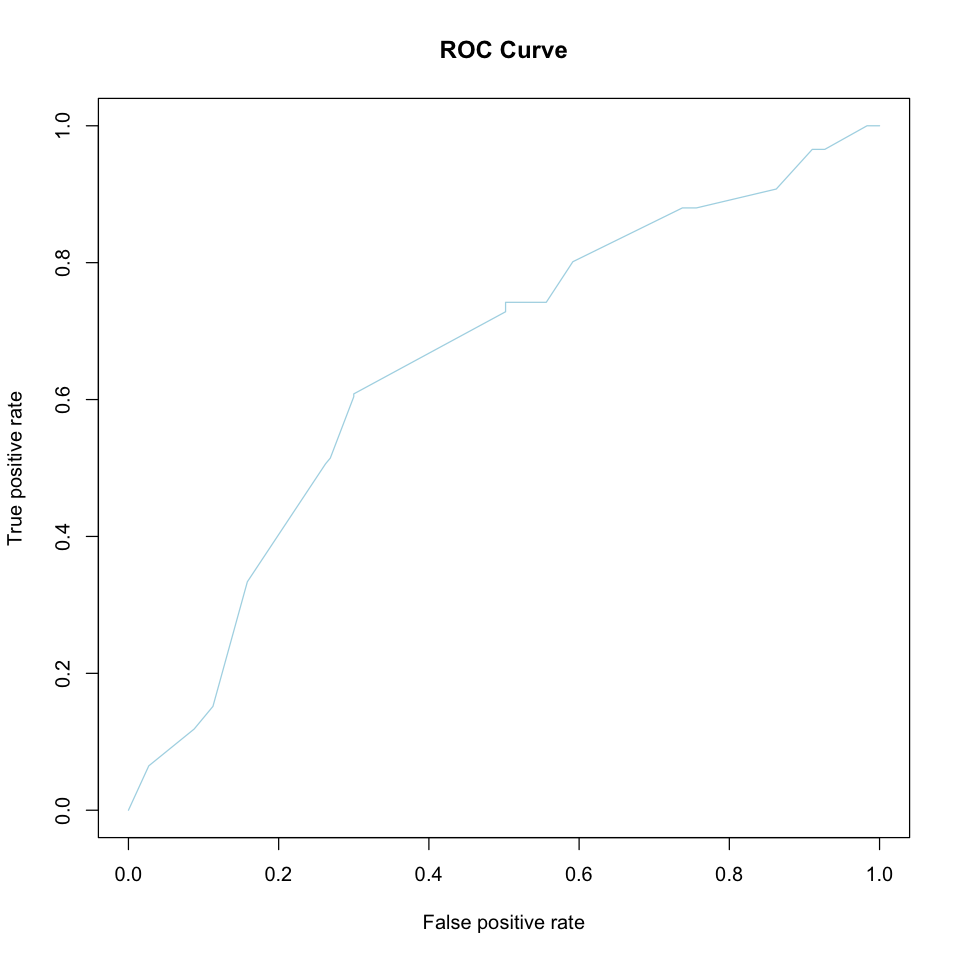

In [142]:
#  Evaluating the Model Performance: Evaluate the model's performance using metrics like:
# Confusion Matrix: To see how well the model predicts high_adaptivity.
# ROC Curve and AUC: To assess the model's ability to discriminate between the two classes

# Confusion Matrix: To see how well the model predicts high_adaptivity
predicted_probabilities <- predict(model, type = "response")
predicted_classes <- ifelse(predicted_probabilities > 0.5, 1, 0)
confusion_matrix <- table(Actual = data$high_adaptivity, Predicted = predicted_classes)
print(confusion_matrix)

# ROC Curve and AUC: To assess the model's ability to discriminate between the two classes
prediction <- prediction(predicted_probabilities, data$high_adaptivity)
performance <- performance(prediction, "tpr", "fpr")

# Plotting the ROC curve 
plot(performance, main = "ROC Curve", col = rgb(0.678, 0.847, 0.902)) 
auc <- performance(prediction, "auc")
print(paste("AUC:", auc@y.values[[1]]))

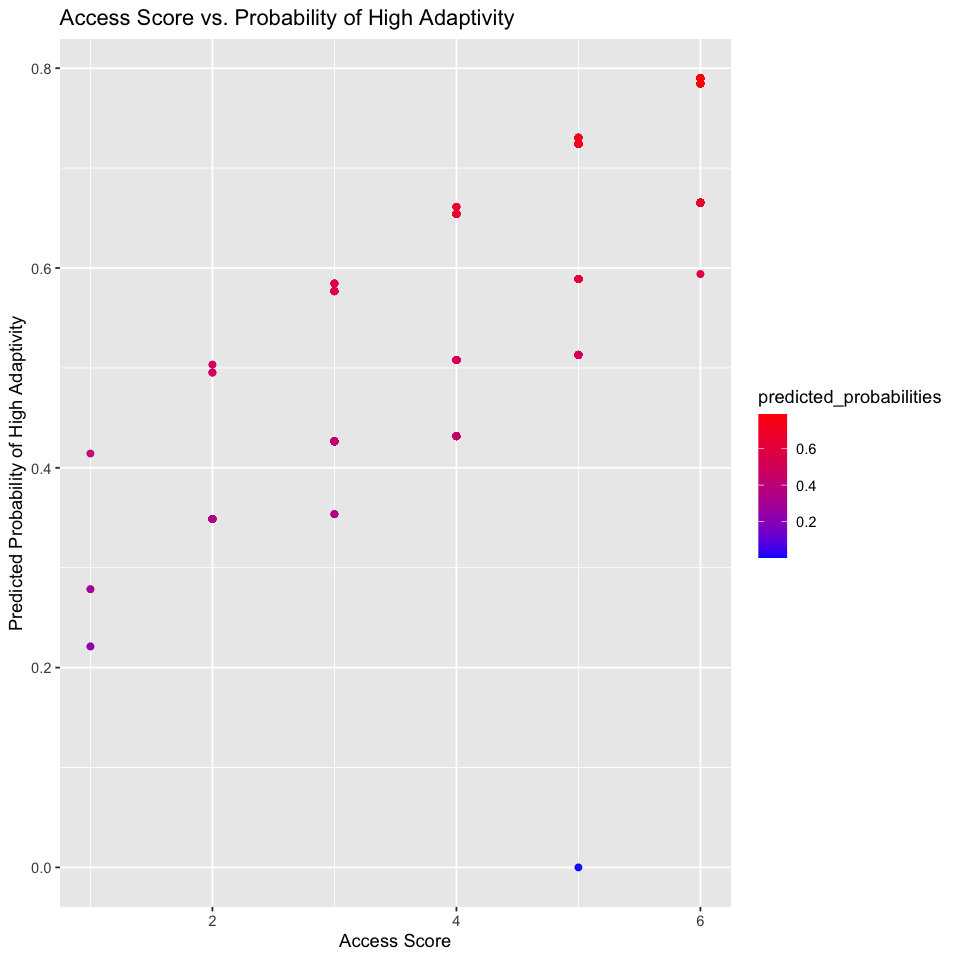

In [143]:
# Scatter Plot (Access Score vs. Probability)
# Scatter Plot (Access Score vs. Probability): To visualize the relationship between access_score and the probability of high_adaptivity

ggplot(data, aes(x = access_score, y = predicted_probabilities, color = predicted_probabilities)) +
  geom_point(alpha = 0.7) +  # Alpha adds transparency to points
  labs(title = "Access Score vs. Probability of High Adaptivity",
       x = "Access Score", 
       y = "Predicted Probability of High Adaptivity") +
  scale_color_gradient(low = "blue", high = "red") 


**Scatter Plot**

- X-Axis (Access Score): This axis represents the numerical access_score you engineered. It reflects a student's access to resources like location, load shedding, internet type, and network type.
- Y-Axis (Predicted Probabilities): This axis represents the predicted probability of high_adaptivity (i.e., "online learning success") as calculated by your logistic regression model.

**Scatter Points**: Each point on the plot represents a student. The position of the point indicates their access_score and the corresponding predicted probability of high_adaptivity.

**Trend:**

- Positive Trend: If you observe an upward trend in the scatter plot (i.e., as access_score increases, the predicted probability of high_adaptivity also tends to increase), it suggests that students with higher access scores are more likely to have high adaptivity.
- No Clear Trend: If the points are scattered randomly with no clear pattern, it suggests that access_score may not be a strong predictor of high_adaptivity.

**Concentration**: observe if the points are concentrated in a specific area of the graph. This can give insight regarding the distribution of the data.

**Logistic Shape**: Ideally, with logistic regression, you might expect to see an "S-shaped" curve if you were to add a smooth line to the scatter plot. However, with discrete access scores, the scatter of points should still indicate a general trend.

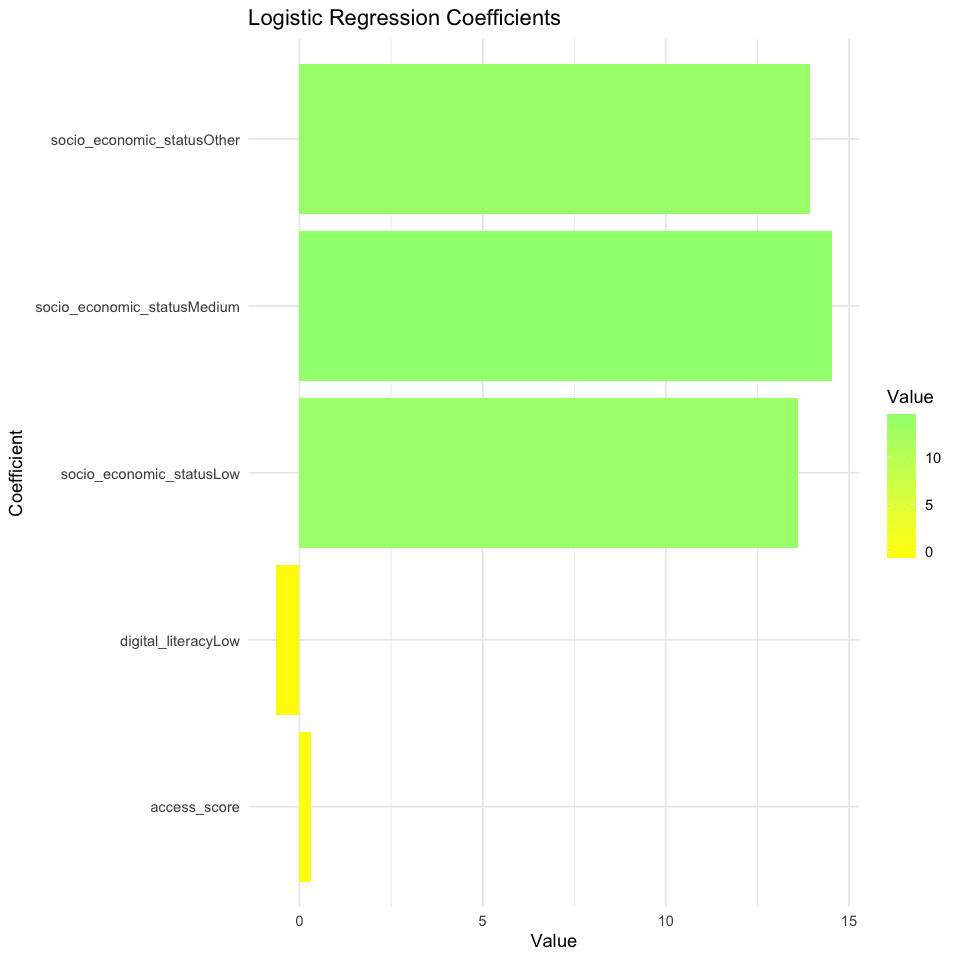

In [144]:
# Coefficient Plot: To show the coefficients of the logistic regression model
coef_data <- data.frame(Coefficient = names(coef(model)), Value = coef(model))

ggplot(coef_data[-1, ], aes(x = Coefficient, y = Value, fill = Value)) +  # Color bars based on Value
  geom_bar(stat = "identity") +
  labs(title = "Logistic Regression Coefficients",
       x = "Coefficient",
       y = "Value") +
  coord_flip() +  # Flip coordinates for better readability
  scale_fill_gradient2(low = "red", mid = "yellow", high = "#9fff80", midpoint = 0) +  # Red for negative, green for positive
  theme_minimal()

**Coefficient Plot: Logistic Regression Coefficients**

- X-Axis (Coefficients): This axis lists the predictor variables included in your logistic regression model (e.g., digital_literacyHigh, socio_economic_statusMedium, access_score). Note that the intercept is excluded using coef_data[-1, ].
- Y-Axis (Value): This axis represents the coefficient values from the logistic regression model.
- Bars: Each bar represents the magnitude and direction of the coefficient for a particular predictor variable.
- 
**Magnitude**:
- The length of the bar indicates the magnitude of the coefficient. Longer bars represent stronger effects.

**Direction**:
- Bars extending to the right (positive values) indicate that an increase in the predictor variable is associated with an increase in the log-odds of high_adaptivity.
- Bars extending to the left (negative values) indicate that an increase in the predictor variable is associated with a decrease in the log-odds of high_adaptivity.

**Categorical Variables**:
For categorical variables (like digital_literacy and socio_economic_status), the plot shows the coefficients for the reference categories.
For example, digital_literacyHigh shows the difference in log-odds between students with High digital literacy, and the students with low digital literacy (the reference group).

**Statistical Significance**:

While the coefficient plot shows the magnitude and direction of the effects, it doesn't directly show statistical significance. It need to refer to the p-values in the logistic regression summary (summary(model)) to determine which coefficients are statistically significant.

#### Summary of Logistic Regression Results

| Predictor Variable               | Coefficient | Standard Error | Z-value | P-value     | Odds Ratio | Interpretation                                                                                                                                                                                                                                                                                                                                                                 |
| :------------------------------- | :---------- | :------------- | :------ | :---------- | :--------- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| (Intercept)                      | -2.8584     | 0.5480         | -5.216  | 1.83e-07    | 0.057      | When all predictors are zero, the odds of high adaptivity are very low.                                                                                                                                                                                                                                                                                                       |
| digital_literacyHigh             | 1.3438      | 0.4402         | 3.053   | 0.00226     | 3.834      | Students with high digital literacy are approximately 3.83 times more likely to have high adaptivity compared to those with low digital literacy, holding other variables constant.                                                                                                                                                                                           |
| socio_economic_statusMedium      | 1.6366      | 0.5342         | 3.064   | 0.00218     | 5.138      | Students with medium socio-economic status are approximately 5.14 times more likely to have high adaptivity compared to those with low socio-economic status (the reference group), holding other variables constant.                                                                                                                                                               |
| socio_economic_statusOther       | -1.8211     | 1.2580         | -1.448  | 0.14771     | 0.162      | The "Other" socio-economic status category is not statistically significant.                                                                                                                                                                                                                                                                                             |
| socio_economic_statusHigh        | 3.1932      | 0.6300         | 5.069   | 3.99e-07    | 24.363     | Students with high socio-economic status are approximately 24.36 times more likely to have high adaptivity compared to those with low socio-economic status (the reference group), holding other variables constant.                                                                                                                                                                 |
| access_score                     | 0.3278      | 0.0545         | 6.017   | 1.78e-09    | 1.388      | For each one-point increase in access score, the odds of high adaptivity increase by approximately 38.8%, holding other variables constant.                                                                                                                                                                                                                                 |


- Coefficients: The coefficients indicate the change in the log-odds of high adaptivity for a one-unit change in the predictor.
- Standard Errors: The standard errors measure the variability of the coefficient estimates.
- Z-values: The z-values are the test statistics for the coefficients.
- P-values: The p-values indicate the statistical significance of the predictors.
- Odds Ratios: The odds ratios (exp(coefficients)) represent the change in the odds of high adaptivity for a one-- unit change in the predictor.


	Fisher's Exact Test for Count Data

data:  table(data$gender, data$high_adaptivity)
p-value = 0.02473
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.6032104 0.9721347
sample estimates:
odds ratio 
 0.7658841 



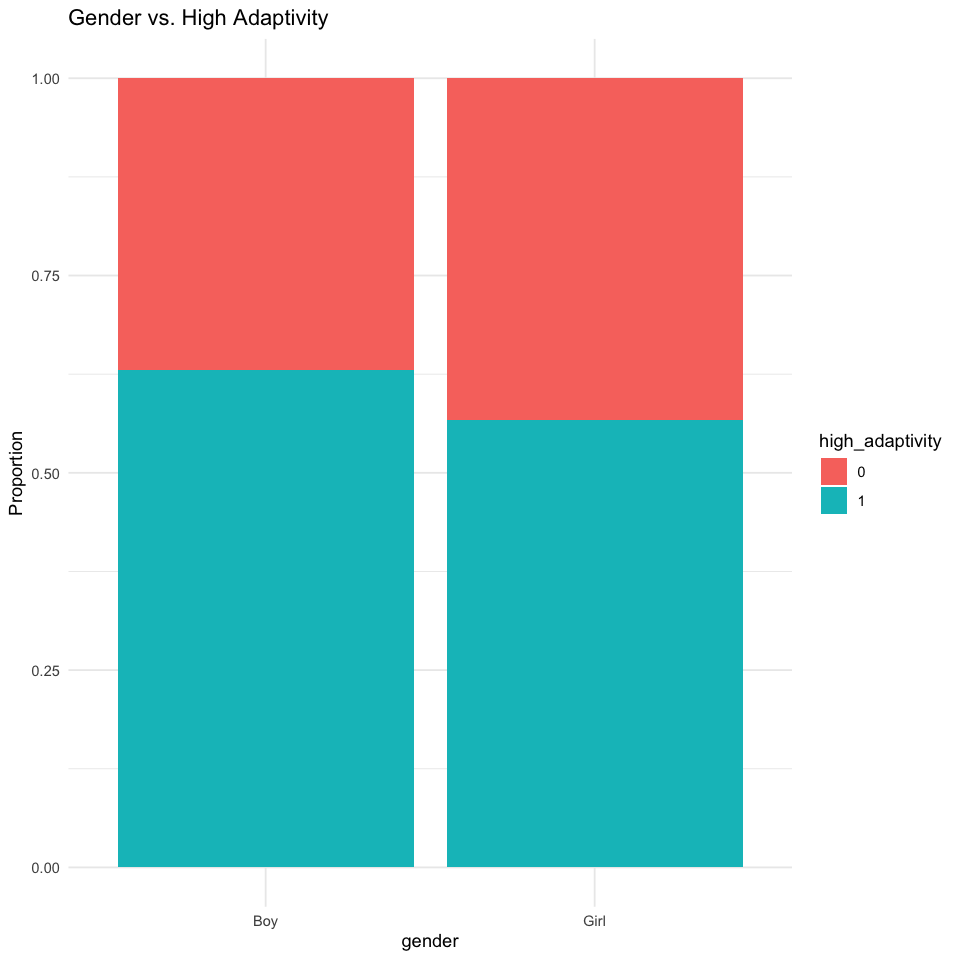

In [145]:
# Gender vs. high_adaptivity

# Bar plot
ggplot(data, aes(x = gender, fill = high_adaptivity)) +
  geom_bar(position = "fill") +
  labs(title = "Gender vs. High Adaptivity", y = "Proportion") +
  theme_minimal()

# Fisher's Exact Test
fisher_gender <- fisher.test(table(data$gender, data$high_adaptivity))
print(fisher_gender)


	Fisher's Exact Test for Count Data

data:  table(data$education_level, data$high_adaptivity)
p-value = 1.513e-06
alternative hypothesis: two.sided



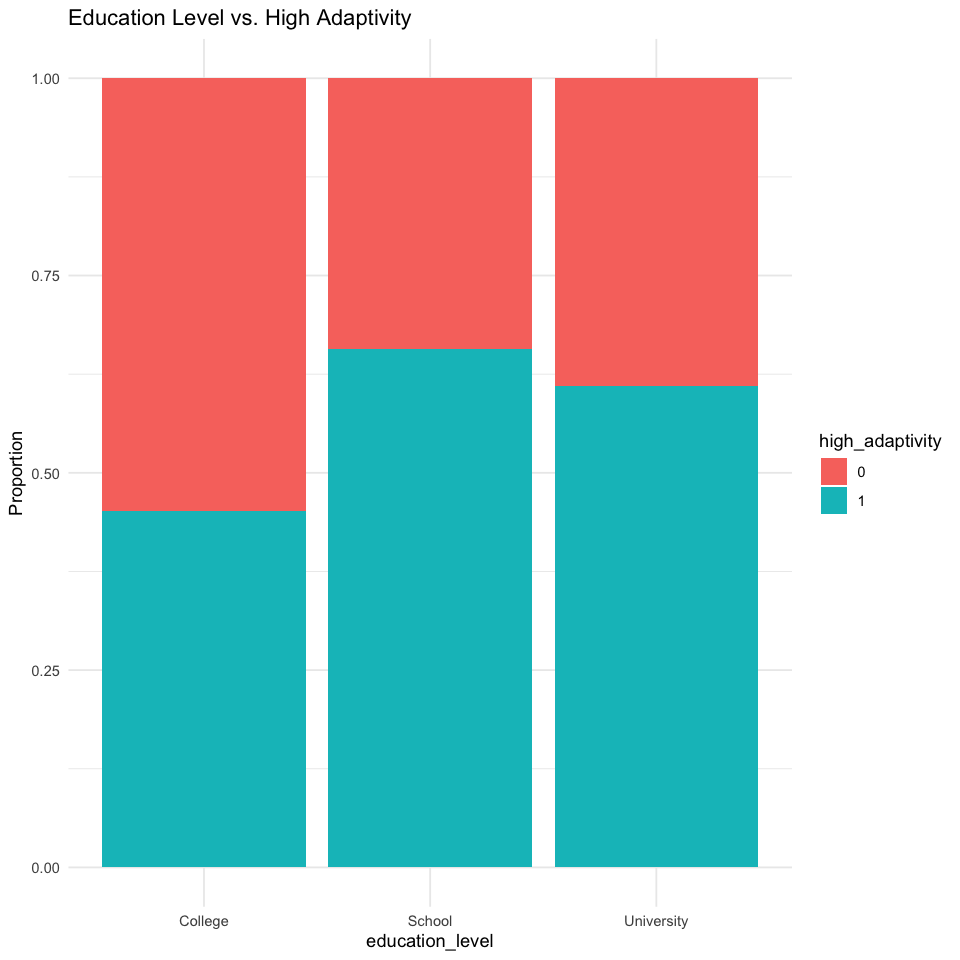

In [146]:
# Education Level vs. high_adaptivity

# Bar plot
ggplot(data, aes(x = education_level, fill = high_adaptivity)) +
  geom_bar(position = "fill") +
  labs(title = "Education Level vs. High Adaptivity", y = "Proportion") +
  theme_minimal()

# Fisher's Exact Test
fisher_education <- fisher.test(table(data$education_level, data$high_adaptivity))
print(fisher_education)